In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import random
import math
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, precision_score
import time
# import cvxopt

In [2]:
n = np.power(10,6)
d = 10
x = np.random.normal(size=(n,d))
error = np.random.normal(size=(n,1))
b = np.random.uniform(size=(d,1))

### in order to avoid Perfect Separation, we need to add some noise
y = x@b + error

In [3]:
class data_generate_process:
    def __init__(self, x, y):
        self.x = x
        self.y = y    
        
    def split(self, rate = 0.7, random_state = 1024, scale = False):
        ## Feature scaling is used to normalize the range of independent variables or features of data
        if scale:
            self.x = (self.x - np.mean(self.x))/x.std()
        
        n = len(self.y)
        np.random.seed(random_state)
        
        ##randomly spilte data into 70% train and 30% test
        index = list(range(n))
        np.random.shuffle(index)
        train = index[:int(rate*n)]
        test = index[int(rate*n):]
        
        self.train_x = self.x[train]
        self.test_x = self.x[test]
        self.train_y = self.y[train]
        self.test_y = self.y[test]
        
        return self.train_x, self.test_x, self.train_y, self.test_y
    
train_x, test_x, train_y, test_y = data_generate_process(x, y).split()

##  $ cost = 1/(pred - true)^2 \; $  for Regression
## $ \theta_L$ = pred - true 
## $ \theta_i = (theta_(i+1)). \dot Weight_i * Activation'(alpha_i) $
##    $ update_i = (\alpha_i.T) . \dot (\theta_(i+1)) $
##  $ weight_i.shape = (\alpha_i.shape[1]+1, \alpha_i.shape[1]+1) $
##  $ weight_L.shape = (\alpha_(L-1).shape[1]+1, 1 \; or  \;labels) $



In [4]:

class neural:
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def complie(self, cost = 'mse', matrix = 'mse'):
        self.cost = cost
        self.matrix = 'mse'
        
    def activation(self, z, function):
        if function == 'linear' : return z
        
        if function == 'sigmod': return 1/(1+ np.exp(-z))

    def deactivation(self, z, function):
        if function == 'linear' : return z
        if function == 'sigmod': 
            f = 1/(1+ np.exp(-z))
            return f*(1-f)  
        
    def addBias(self, x):
        ones = np.ones((x.shape[0], 1))
        return np.hstack((ones,x)) 
        
    def decost(self, pred, true):
        if self.cost == 'mse':  return pred - true
    
    def dense(self, nodes = [], pred = [] , out = 'linear', functions = ['sigmod'], hidden = 2):
        
        
        if out == 'linear': pred = 1
        else: pred = len(np.unique(y))
        
        n, d = self.x.shape
        
        if not nodes:
            nodes = [int(np.sqrt(d*pred))+1]
        

        while len(nodes) != hidden:
            nodes.append(nodes[0])
        
        nodes = [d] + nodes + [pred]
        
        self.nodes = nodes
        
        while len(functions) != hidden:
            functions.append(functions[0])

        functions = ['input'] + functions+ [out]
        
        
        ## numbers of layers is the numbers of hidden layer plus the input and output layer
        
        layers = {number+1:[nodes[number], functions[number]] for number in range(hidden+2)}  

        self.layers = layers
        
        
        print(layers)
        return layers

    def make_weights(self, random_start):
        
        layers = self.layers
        layer = len(layers)
        
        
        ## dimension of weights is the dimension of input+1 (add bias) times the dimension of the next layer +1 
        ## except the out layer
        
        if random_start == 0:
            weights = {item:np.ones((layers[item][0]+1, layers[item+1][0]+1)) for item in range(1, layer-1)}
            weights[layer-1] = np.ones((layers[layer-1][0]+1, 1))
            return weights
        
        np.random.seed(random_start)
        weights = {item:np.random.rand(layers[item][0]+1, layers[item+1][0]+1) for item in range(1, layer-1)}
        weights[layer-1] = np.random.rand(layers[layer-1][0]+1, 1)
        return weights
        
    def windows(self, batch):
        ## random pop batch size of sampling
        index = list(range(len(self.x)))
        np.random.shuffle(index)

        return self.x[index[:batch]], self.y[index[:batch]]
    
    def forward(self, weights, x = None):
        if x is None:
            x = self.x
            
        next_input = [self.addBias(x)]
        
        for i in range(1, len(weights)+1):
            next_input.append(next_input[i-1]@weights[i])
        return next_input
    

    def ward(self, x, weight, error, function):
        
        ## there is no error for the input layer
        if function =='input':
            return x.T@error, _
        
        derivate = self.deactivation(x, function)
        return x.T@error, error@weight.T*derivate
    
    def back(self, next_input, weights, y, learning):
        number = len(self.layers)
        error ={number:self.decost(next_input[number-1], y)}
        
        update = []
        for layer in range(number-1, 0, -1):
            update, error[layer] = self.ward(next_input[layer-1], weights[layer], error[layer+1], self.layers[layer][1])
            if np.isnan(update).any():
                return weights, 0
            weights[layer] -= learning*update
            
        return weights, np.sum(abs(update))
    
    def fit(self, threshold = 10e-3, batch = 256, epochs = 10 ,random_start = 0 , learning = []):
        
        weights = self.make_weights(random_start)
        
        
        if not learning:
            learning = 1/np.power(2, len(self.layers)+ self.nodes[1]+self.x.shape[1])
        
        for epoch in range(epochs):
            
            ## automatically reduce the learning step
            learning = learning /(epoch+1)
            
            x, y = self.windows(batch)
                               
            next_input = self.forward(weights, x)
            print('epoch {epoch} of {epochs} with mse {mse}'.format(epoch = epoch+1, epochs = epochs, mse = self.mse(next_input[-1], y) ))
            weights, update = self.back(next_input, weights, y, learning)
            
            if update <= threshold: return
            
            self.weights = weights
            
    
    def predict(self, x):
        pred = self.forward(self.weights, x)[-1]
        return pred
    
    def mse(self,pred, true):
        error = pred - true
        return error.T@error/len(error)


In [5]:
start = time.time()
model = neural(train_x, train_y)
model.dense()
model.complie(cost = 'mse', matrix = 'mse')
model.fit(random_start = 0)

{1: [10, 'input'], 2: [4, 'sigmod'], 3: [4, 'sigmod'], 4: [1, 'linear']}
epoch 1 of 10 with mse [[6394.44779124]]
epoch 2 of 10 with mse [[546.26132455]]
epoch 3 of 10 with mse [[95.655366]]
epoch 4 of 10 with mse [[63.22396424]]
epoch 5 of 10 with mse [[53.96255601]]
epoch 6 of 10 with mse [[59.48561139]]
epoch 7 of 10 with mse [[43.08762748]]
epoch 8 of 10 with mse [[46.9129681]]
epoch 9 of 10 with mse [[52.32381729]]
epoch 10 of 10 with mse [[44.88919778]]


In [6]:
## mse
pred = model.predict(test_x)
my_mse = np.square(pred - test_y).sum()/len(pred)
end = time.time()
my_time = end - start

###  SKlearn

In [7]:
from sklearn.neural_network import MLPRegressor
start = time.time()
y_train = train_y.T
regr = MLPRegressor().fit(train_x, train_y.ravel())

In [8]:
pred = regr.predict(test_x)
sk_mse = np.square(pred.reshape(-1,1) - test_y).sum()/len(pred)
end = time.time()
sk_time = end - start

# comparison

Text(0.5, 1.0, 'MSE')

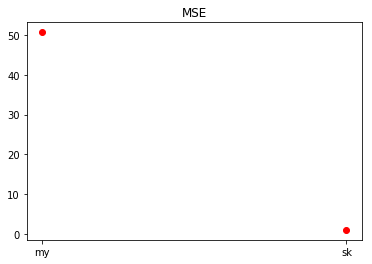

In [11]:
plt.plot(['my','sk'],[my_mse, sk_mse],'ro')
plt.title('MSE')

Text(0.5, 1.0, 'Time')

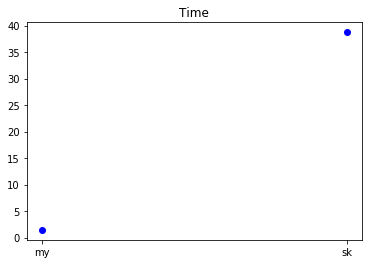

In [12]:
plt.plot(['my','sk'],[my_time, sk_time],'bo')
plt.title('Time')